# MP6: Transformers for Language Modeling

### Introduction

In this notebook, I will be implementing a 'Transformer' model, namely `CheapGPT`, from scratch. The transformer architecture is understood and taken from this paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017). I will be training the transformer for a language modeling task on a dataset comprising of `Eminem` songs.

### Importing Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import tiktoken # used for converting text into tokens using BPE (byte pair encoding)

### Sourcing the Dataset

This section primarily involves doing the following:

1. **Finding/Downloading/Creating the dataset**.

2. **Preprocessing the dataset**. This involves tokenizing the dataset, and creating a vocabulary. We will use **subword-level tokenization** (different tokenization strategies can be found [here](https://huggingface.co/learn/nlp-course/chapter2/4?fw=pt)). This can be very easily handled with the imported `tiktoken` library (read up on this library from [here](https://github.com/openai/tiktoken)).

In [6]:
# the yt video I followed throughout this notebook for help: https://www.youtube.com/watch?v=kCc8FmEb1nY

# I choose the 'All_eminem.txt' dataset because who doesnt love saleem shaddy ;) lol. 
# The dataset comprises of about 224 songs from all eminems albums excluding the intros, the skits and the outros. I found it on Kaggle posted by some dude who was also working on a NLP project of his own and used the same dataset. 
# The data set has exactly 23629 lines of text which I think will serve well with my transformer model as Eminem's songs offer a wide variety of style, richness and complexity than other artists. 
# The dataset is uploaded online at this link: https://www.kaggle.com/datasets/thaddeussegura/eminem-lyrics-from-all-albums

BATCH_SIZE = 32
BLOCK_SIZE = 8

# Creating a tiktoken object
encoder = tiktoken.get_encoding("gpt2")

# Read the dataset
path_to_it_script = 'ALL_eminem.txt'
with open(path_to_it_script, 'r', encoding = 'utf-8') as file:
    script_text = file.read()
    
# Creating the encoded ids using the encoder
encoded_ids = encoder.encode(script_text)

def get_batch():
    '''
    Returns a batch (x, y) from the dataset
    '''
    # Gets random integers for indexing into the dataset to create a batch
    start_indices = np.random.randint(0, len(encoded_ids) - BLOCK_SIZE, size = BATCH_SIZE)

    # Getting the x and y (input and target) batches after encoding and indexing
    x = [encoded_ids[i : i + BLOCK_SIZE] for i in start_indices]
    y = [encoded_ids[i + 1 : i + BLOCK_SIZE + 1] for i in start_indices] # shifted to the right by one index as y is the target 
    
    # Making sure these are int64 (long) tensors
    x = torch.tensor(x, dtype = torch.int64)
    y = torch.tensor(y, dtype = torch.int64)

    return x, y

xb, yb = get_batch()
xb.shape, yb.shape

(torch.Size([32, 8]), torch.Size([32, 8]))

### Creating the Transformer

We will begin by defining our hyperparameters here.

Since there are lots of hyperparameters to keep track of, it is easier for us to wrap all of them inside a `dataclass`. This can be passed around very easily to different functions, and makes it easier to keep track of all relevant values.

To quickly describe some of the hyperparameters:

1. `block_size`: This is the length of the sequence that we will be feeding into our model. This has also been called the *context length* and *window size* in other places.

2. `emb_dim`: This is the dimensionality of the embeddings we will have inside the model. This has implications on the outputs of tensors throughout the entire model.

3. `head_size`: When dealing with Multi-Head Attention, we will be *splitting* our embeddings into multiple heads. This is the size of each of those heads. For example, if we had an embedding of size 512, and we wanted 8 heads, then each head would have a size of 64. Down the line, we'd be concatenating these heads together, so the final output would be of size 512 again, as you should recall from the lectures.

4. `num_heads`: This is the number of attention heads we will have in our Multi-Head Attention layer.

5. `num_layers`: This is the number of layers we will have in our Transformer (this includes the MHSA, the Feedforward module, and the Layer Normalizations).

6. `vocab_size`: This is the size of our vocabulary. This is the number of unique tokens we have in our vocabulary. If you were to use character-level tokenization, this would be the number of unique characters in your dataset. Since you should be using subword-level tokenization, this will be the number of unique subwords in your dataset.

In [7]:
from dataclasses import dataclass

@dataclass
class Config:
    block_size: int = BLOCK_SIZE
    emb_dim: int = 256
    head_size: int = 32
    num_heads: int = 8
    num_layers: int = 2
    vocab_size: int = encoder.n_vocab # vocab size of the tokenizer

# We like to have emb_dim == head_size * num_heads
config = Config()
assert config.emb_dim == config.head_size * config.num_heads, "Embedding dimension must be divisible by number of heads"

### Implementing Multi-Head Self-Attention

This component is the core of the Transformer. This is where the model learns to attend to different parts of the input sequence, and is the reason why Transformers are so powerful.

$$\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$

$$\text{head}_k = \text{Attention}(QW^Q_k, KW^K_k, VW^V_k)$$

$$\text{MHSA}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

For simplicity, assume we have a single Head:

1. The input has three parts extracted from it: the query $Q$, the key $K$, and the value $V$ (via projections or `Linear` layers). 

2. The query and key are multiplied together to get a score. This score is then scaled by the square root of the embedding dimension, $\sqrt{d_k}$, then passed through a softmax to get the attention weights (*after* a masking operation is applied).

3. The attention weights are then multiplied with the value to get the final output.

When we extend this to *multiple heads*, we simply repeat this process for each head in parallel, and then concatenate the outputs of each head together.

Below, I have created a class for this `MHSA` module (Multi-Head Self-Attention), adding a comment next to each line in the `forward` method for the shape of the tensor at that point.

In [8]:
class MHSA(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.emb_dim = cfg.emb_dim
        self.head_size = cfg.head_size
        self.block_size = cfg.block_size
        self.num_heads = cfg.num_heads

        # Defining the single projection layer for QKV
        self.QKV_layer = nn.Linear(self.emb_dim, 3 * self.emb_dim)

        # Defining the output projection layer
        self.projection = nn.Linear(self.emb_dim, self.emb_dim)

        # Creating a buffer for the mask (buffers are tensors that are not updated during backpropagation)
        self.register_buffer("mask", torch.tril(torch.ones(self.block_size, self.block_size)))

    def forward(self, x):

        B, T, C = x.shape # batch size, block size, emb dim
        H = self.num_heads

        # Carrying out the projections to get the query, key and value - you may want to reshape them to (B, H, T, head_size) to make things easier

        QKV = self.QKV_layer(x)
        Q, K, V = torch.split(QKV, self.emb_dim, dim = -1)
        
        # shape: (B, H, T, head_size) for Q, K and V
        Q = Q.view(B, T, H, self.head_size).transpose(1, 2)
        K = K.view(B, T, H, self.head_size).transpose(1, 2)  
        V = V.view(B, T, H, self.head_size).transpose(1, 2)

        # Computing the attention scores, perform masking, and apply the softmax
        attention_scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(self.head_size)

        mask = self.mask[:T, :T]  # shape: (1, 1, T, T)
        attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        weights = torch.softmax(attention_scores, dim = -1)  # shape: (B, H, T, T)

        final_output = weights @ V  # shape: (B, H, T, head_size)

        # Computing the weighted sum of the value vectors - you can perform the concatenation via a simple reshaping before applying the final projection
        final_output = final_output.transpose(1, 2).contiguous().view(B, T, C)  # shape: (B, T, C)
        final_output = self.projection(final_output)  # shape: (B, T, C)

        return final_output

x = torch.randn(32, config.block_size, config.emb_dim)
print(x.shape)
csa = MHSA(config)
out = csa(x)
print(out.shape)

torch.Size([32, 8, 256])
torch.Size([32, 8, 256])


### The Feedforward Network

The Feedforward Network module usually consists of two linear layers, with a ReLU activation in between. The first linear layer projects the input's Embeddings to a higher dimensionality (by a factor of 4 specifically), and the second linear layer projects it back down to the original dimensionality. This is a very simple module, but is very effective in learning complex functions.

Creating a class for this `Feedforward` module, with the following tweaks:

1. Using the [GELU Activation Function](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) instead of ReLU between the layers. It is functionally very similar, but has gained a lot of popularity as well.

2. Instead of using two `Linear` layers, and an upsampling factor of `4`, use **three** `Linear` layers: the first one upsamples by a factor of `2`, the second one does not change the dimensionality, and the third one downsamples by a factor of `2`. This creates a slightly deeper network, and can be shown to have the same number of parameters as the network in the original Transformer.

3. Adding a [Dropout layer](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) after the last `Linear` layer, with $p=0.1$. This helps mitigate overfitting.

In [9]:
class Feedforward(nn.Module):
    def __init__(self, config):
        super().__init__()
        emb_dim = config.emb_dim

        # Defining the feedforward network
        self.linear1 = nn.Linear(emb_dim, emb_dim * 2) # upsampling by a factor of 2 as specified
        self.linear2 = nn.Linear(emb_dim * 2, emb_dim * 2) # no change in dimentionality
        self.linear3 = nn.Linear(emb_dim * 2, emb_dim) # downsampling by a factor of 2
        self.activation = nn.GELU() # using stated 'famous' activation function
        self.dropout = nn.Dropout(p = 0.1) # doing as told

    def forward(self, x):
        # Applying the feedforward network
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.dropout(x)

        return x

### Blocks with Skip Connections

The Encoder consists of multiple *Blocks*, that each contain a Multi-Head Self-Attention module, a Feedforward module, and a Layer Normalization module. We use Skip Connections to help with the flow of gradients during the training process.

Creating a class for this `Block` module, with the following tweaks:

- Instead of creating my own Layer Normalization module, I used [the one provided by PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html), `nn.LayerNorm`.

- Performing the Layer Normalizations **before** the Skip Connections, instead of after. The original paper used the "post-LN" approach, but [recent research](https://arxiv.org/abs/2002.04745) has shown that the "pre-LN" approach is better.

In [10]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Defining the MHSA, Feedforward, and two LayerNorm modules
        self.norm1 = nn.LayerNorm(config.emb_dim)
        self.norm2 = nn.LayerNorm(config.emb_dim)
        self.mhsa = MHSA(config)
        self.ffn = Feedforward(config)


    def forward(self, x):

        # Applying the modules with residual connections (use the Pre-LN design)
        x = x + self.mhsa(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        
        return x

x = torch.randn(8, config.block_size, config.emb_dim)
print(x.shape)
block = Block(config)
out = block(x)
print(out.shape)

torch.Size([8, 8, 256])
torch.Size([8, 8, 256])


### Putting it all together

Now that we have all the components, we can put them together to create the Transformer. The Transformer consists of:

1. Creating Embeddings for the input sequence. This implies turning the input sequence into a sequence of indices, and then passing it through an `nn.Embedding` layer. Alongside this, we will be using another Embedding table for the positional encodings. For simplicity, we can keep the embedding dimensionality for both of these the same.

2. Passing the embeddings through a series of Blocks.

3. Passing the output of the Encoder through a Layer Normalization layer, and then a Linear layer to get the final logits.

Create a class for this `CheapGPT` module. This will be the final model that we will be training.

In [24]:
class SastaGPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb_dim = config.emb_dim
        self.block_size = config.block_size
        self.num_layers = config.num_layers
        self.vocab_size = config.vocab_size 

        # Defining the word and position embeddings
        # Hint: They will both have the same embedding dimension, only difference is the number of embeddings (vocab_size vs. block_size)
        self.word_embeddings = nn.Embedding(self.vocab_size, self.emb_dim) # same embedding's dimentionality as stated
        self.position_embeddings = nn.Embedding(self.block_size, self.emb_dim)

        # Defining the sequence of Blocks
        self.blocks = nn.ModuleList([Block(config) for _ in range(self.num_layers)])

        # Defining the final LayerNorm
        self.final_layer_for_normalisation = nn.LayerNorm(Config.emb_dim)
        
        # Defining the final linear layer (to get logits)
        self.final_linear_layer = nn.Linear(self.emb_dim, self.vocab_size)

        # Initializing the weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idxs):
        # idxs: (B, T)
        batch_size, seq_len = idxs.shape

        assert seq_len <= self.block_size, f"Sequence length exceeds block size of {self.block_size}"

        # Getting the word embeddings (B, T, C) and position embeddings (T, C). For the position embeddings, we can use torch.arange(seq_len) to mimic the indices
        # Note: position embeddings are encodings of the position indices (NOT the actual tokens)
        word_embeddings = self.word_embeddings(idxs) # getting word embeddings of input token indices
        position_embeddings = self.position_embeddings(torch.arange(seq_len).to(idxs.device)) # getting position embeddings 

        # Adding the word and position embeddings (broadcasting will take care of the shapes)
        embeddings = word_embeddings + position_embeddings.unsqueeze(0)

        # Passing the embeddings through the blocks (B, T, C)
        for block in self.blocks:
            embeddings = block(embeddings) # updating the embeddings at each step as they are passed onto the blocks

        # Applying the final LayerNorm
        embeddings = self.final_layer_for_normalisation(embeddings)

        # Applying the final linear layer to get the logits (B, T, V)
        logits = self.final_linear_layer(embeddings)

        return logits
    
    @torch.no_grad()
    def generate(self, idxs, max_new_tokens=20):
        '''
        Takes in a sequence of indices (the tokenized sentence) and generates new tokens
        Note that the input indices should not be longer than the block size
        Returns the input sequence with the generated tokens appended (these should be decoded using the Tokenizer)

        Params
        ------
        idxs: torch.Tensor
            (B, T) tensor of token indices
        max_new_tokens: int
            Maximum number of new tokens to generate
        ''' 
        
        # Moving idxs to the same device as the model
        idxs = idxs.to(next(self.parameters()).device)

        # idxs: (B, T)
        for _ in range(max_new_tokens):
            idxs_trimmed = idxs[:, -self.block_size:] # trim to block size

            logits = self(idxs_trimmed) # (B, T, V)

            logits = logits[:, -1, :] # (B, V)
            
            probs = F.softmax(logits, dim=-1) # (B, V)

            next_idx = torch.multinomial(probs, num_samples=1) # (B, 1)

            idxs = torch.cat((idxs, next_idx), dim=1) # (B, T+1)
            
        return idxs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cfg = Config()
model = SastaGPT(cfg)
model = model.to(device)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()) / 1e6 :.3f}M")

Number of parameters: 27.364M


In [25]:
# Checking out the forward pass
xb, yb = get_batch()
print(xb.shape)

logits = model(xb)
print(logits.shape) # (B, T, V)

torch.Size([32, 8])
torch.Size([32, 8, 50257])


### Now we train this model on the dataset!

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training the model
def get_torch_batch():
    xb, yb = get_batch()
    xb = xb.clone().detach().to(device)
    yb = yb.clone().detach().to(device)
    return xb, yb

cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

number_of_epochs = 10000

# Casting the model to the device
model = model.to(device)

# Training loop
for epoch in range(number_of_epochs):
    model.train()
    xb, yb = get_torch_batch()
    preds = model(xb)
    loss = cross_entropy_loss(preds.view(-1, model.vocab_size), yb.view(-1)) # calculating the loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # printing the training information
    print(f'Epoch [{epoch+1}/{number_of_epochs}], Loss: {loss.item()}')

# saving the trained model
torch.save(model.state_dict(), 'sasta_gpt_model.pth')

Epoch [1/10000], Loss: 2.960808753967285
Epoch [2/10000], Loss: 3.3931992053985596
Epoch [3/10000], Loss: 2.889049768447876
Epoch [4/10000], Loss: 2.921827554702759
Epoch [5/10000], Loss: 3.0422520637512207
Epoch [6/10000], Loss: 2.7901556491851807
Epoch [7/10000], Loss: 2.712486505508423
Epoch [8/10000], Loss: 2.955739736557007
Epoch [9/10000], Loss: 3.265850782394409
Epoch [10/10000], Loss: 3.336750030517578
Epoch [11/10000], Loss: 2.6227705478668213
Epoch [12/10000], Loss: 2.746769428253174
Epoch [13/10000], Loss: 3.32938289642334
Epoch [14/10000], Loss: 2.919477701187134
Epoch [15/10000], Loss: 3.007491111755371
Epoch [16/10000], Loss: 2.609490394592285
Epoch [17/10000], Loss: 2.8085246086120605
Epoch [18/10000], Loss: 2.5081448554992676
Epoch [19/10000], Loss: 2.858814239501953
Epoch [20/10000], Loss: 2.9863440990448
Epoch [21/10000], Loss: 3.3222923278808594
Epoch [22/10000], Loss: 2.751042604446411
Epoch [23/10000], Loss: 3.128535747528076
Epoch [24/10000], Loss: 2.7152826786041

With the trained model, lets generate some text and see how well the model performs. I will be using the generate() function for this.

The quality of the generations depends on:

- How large the training dataset was. If a small dataset was used, the model will not have enough samples to learn the syntax, semantics, the grammar and other intricacies of language, much less the specifics of the dataset.

- How long the model was trained for.

- How large was the model. If a small model was used, it will not have enough parameters to learn the complexities of language.

In [43]:
sentence = "machine learning is"
idxs = torch.tensor(encoder.encode(sentence)).unsqueeze(0)

model.eval()
generated = model.generate(idxs, max_new_tokens=100)
res = encoder.decode(generated[0].cpu().numpy())
print(res)

machine learning is a hit of, the wolves fear, this world keep just that low her
I'm in my back room dark again
I went to risk it, I'm calm as I am
Fack, fack fack, fack I amukin'
Pass the K-S
To a view with your spider sense either
I ain't there but wouldn't be with me knocking, I'm glad an air
And jump your bones to your radio, but whats himself happened


## Effects of Hyperparameters on the Number of Parameters

In this section, we will be exploring the effects of the hyperparameters on the number of parameters in your model. 

With so much room for tweaking (with the embedding dimensionality, the size of the vocab, the number of heads, the number of layers, etc.), it is important to visualize how fast the total number of parameters can grow if we start toying with them.

In [44]:
def get_params(model):
    '''
    Returns the number of parameters in the model (in millions)
    '''
    return sum(p.numel() for p in model.parameters()) / 1e6

@dataclass
class Config:
    block_size: int = BLOCK_SIZE
    emb_dim: int = 256
    head_size: int = 32
    num_heads: int = 8
    num_layers: int = 2
    vocab_size: int = 100 # smaller vocab size for quick prototyping

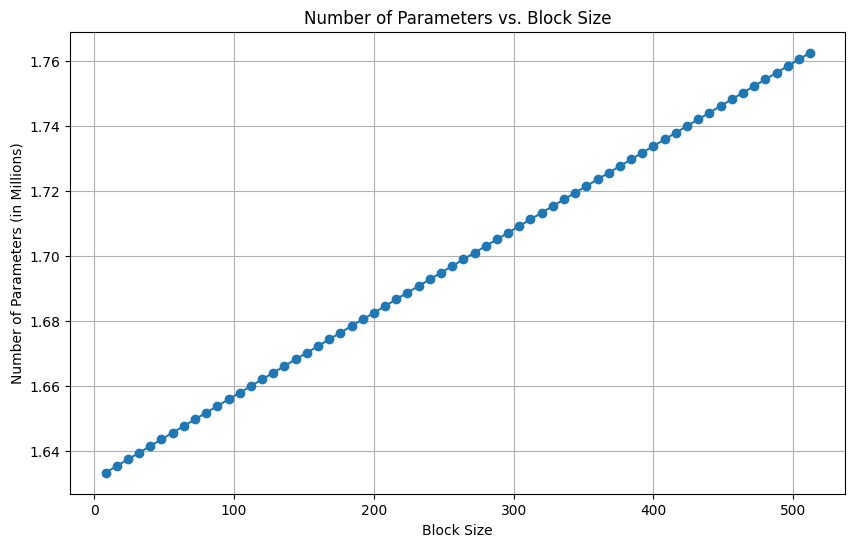

In [45]:
#  Plotting the number of parameters vs. block size (in multiples of 8, capped at 512)

block_sizess = list(range(8, 513, 8))

num_params_list = []

for block_size in block_sizess:

    config = Config(block_size = block_size)
    model = SastaGPT(config)
    num_params = get_params(model)
    num_params_list.append(num_params)

plt.figure(figsize = (10, 6))
plt.plot(block_sizess, num_params_list, marker='o')
plt.title('Number of Parameters vs. Block Size')
plt.xlabel('Block Size')
plt.ylabel('Number of Parameters (in Millions)')
plt.grid(True)
plt.show()

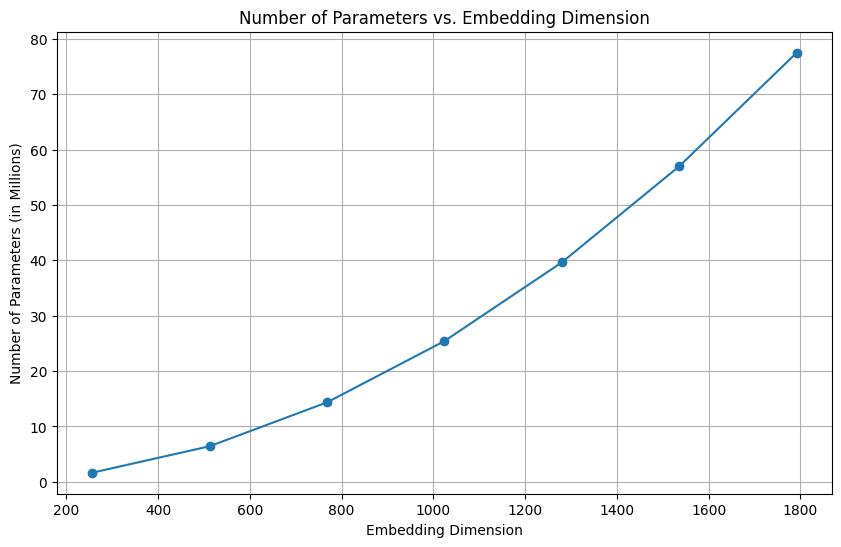

In [46]:
# Plotting the number of parameters vs. embedding dimension (in multiples of 256, capped at 1792)

emb_dimss = list(range(256, 1793, 256))

num_params_list = []

for an_emb_dim in emb_dimss:
    
    config = Config(emb_dim = an_emb_dim)
    model = SastaGPT(config)
    num_params = get_params(model)
    num_params_list.append(num_params)

plt.figure(figsize = (10, 6))
plt.plot(emb_dimss, num_params_list, marker='o')
plt.title('Number of Parameters vs. Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('Number of Parameters (in Millions)')
plt.grid(True)
plt.show()

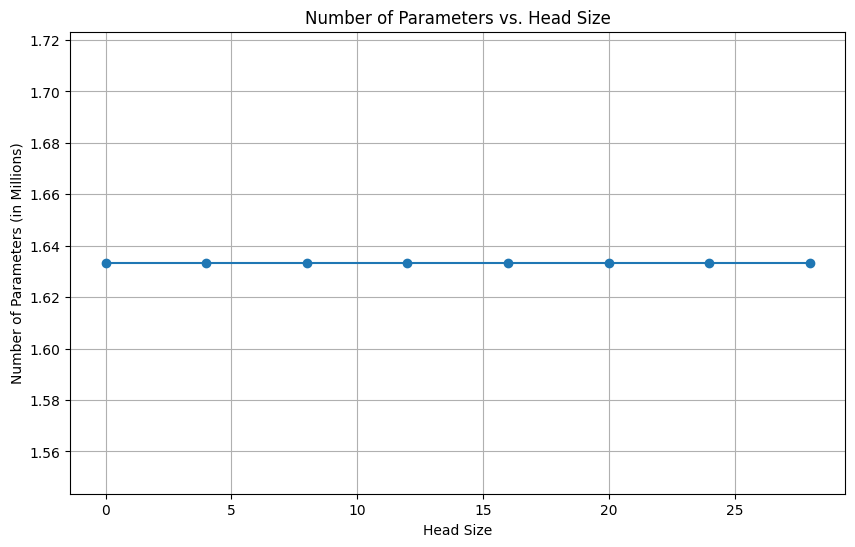

In [48]:
# Plotting the number of parameters vs. number of heads (in multiples of 4, capped at 32)

heads = list(range(0, 32, 4))
num_params_list = []

for a_head in heads:
    
    config = Config(head_size = a_head)
    model = SastaGPT(config)
    num_params = get_params(model)
    num_params_list.append(num_params)

plt.figure(figsize = (10, 6))
plt.plot(heads, num_params_list, marker='o')
plt.title('Number of Parameters vs. Head Size')
plt.xlabel('Head Size')
plt.ylabel('Number of Parameters (in Millions)')
plt.grid(True)
plt.show()

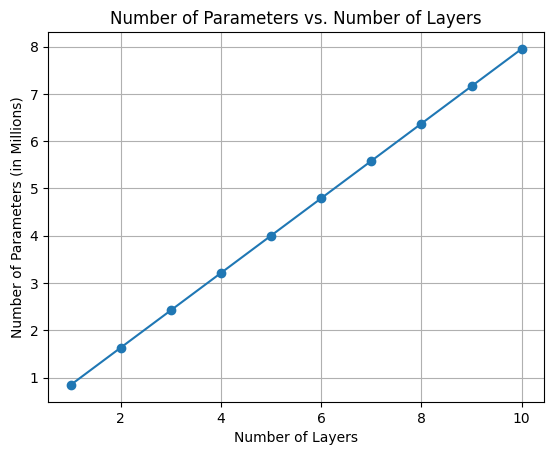

In [49]:
# Plotting the number of parameters vs. number of layers

num_layers_range = range(1, 11) 
num_params = []

for num_layers in num_layers_range:

    config = Config(num_layers=num_layers)
    model = SastaGPT(config)
    num_params.append(get_params(model))

plt.plot(num_layers_range, num_params, marker='o')
plt.xlabel('Number of Layers')
plt.ylabel('Number of Parameters (in Millions)')
plt.title('Number of Parameters vs. Number of Layers')
plt.grid(True)
plt.show()

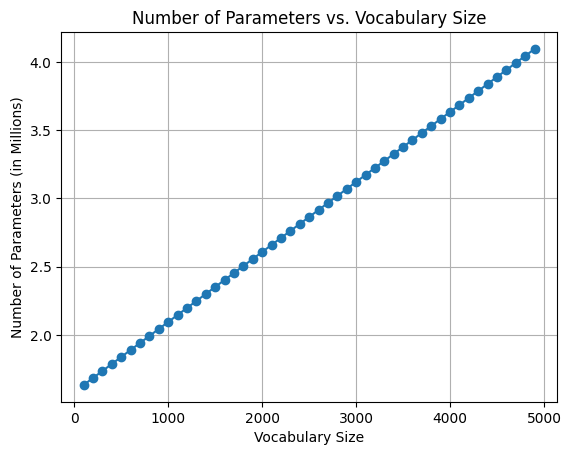

In [50]:
# Plotting the number of parameters vs. vocabulary size

vocab_size_range = range(100, 5000, 100) 
num_params = []

for vocab_size in vocab_size_range:

    config = Config(vocab_size=vocab_size)
    model = SastaGPT(config)
    num_params.append(get_params(model))

plt.plot(vocab_size_range, num_params, marker='o')
plt.xlabel('Vocabulary Size')
plt.ylabel('Number of Parameters (in Millions)')
plt.title('Number of Parameters vs. Vocabulary Size')
plt.grid(True)
plt.show()

Fin.